In [1]:
import data_smoothing
import find_peaks
import peak_character

# Load TA data

In [2]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp03_20180103 -t0 -chirp.csv')

# Smooth data

In [3]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


# Find Peaks

In [110]:
threshold = 0.75
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

# Visualizer Function

In [111]:
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import pandas as pd

def visualize(peak_dict):
    for i in range(len(peak_dict)):
        df = pd.DataFrame(peak_dict['peak_%s' % i], 
        columns=['Position', 'Height', 'Width', 'Time'])
        
        plt.subplot(3, 1, 1)
        plt.plot(df['Time'], df['Height'], '.')
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(df['Time'], df['Position'], '.')
        plt.ylabel('Position')
        plt.ylim((0, 144))

        plt.subplot(3, 1, 3)
        plt.plot(df['Time'], df['Width'], '.')
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()
    return

# Classify Peaks - KMeans

In [112]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    fill_na = all_points.fillna(value=0)
    corrected_output = fill_na.drop(fill_na[abs(fill_na.Height) < 0.001].index)
    corrected_output = corrected_output.reset_index(drop=True)
    
    return corrected_output

def KMeans_cluster_classifier(index_df, corrected_output):
    found_peak = index_df.shape[1]
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-2])
    print(cluster.labels_)
    print(cluster.cluster_centers_)
    peak_dict = {}
    
    for i in range(found_peak):
            peak_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-2]])
        signal = corrected_output.loc[j][1]
        for k in range(found_peak):
            if (peak == k):
                peak_dict['peak_%s' % k].append(corrected_output.values[j])
                #print('found a match')

    return peak_dict

In [113]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output.describe()

,Position,Height,Width,Time
count,758.000000,758.000000,758.000000,758.000000
mean,46.616095,-0.001526,173.460897,420.346966
std,15.826223,0.000647,40.283201,201.244542
min,15.000000,-0.004840,75.358000,88.000000
25%,52.000000,-0.001417,161.780000,240.000000
50%,55.000000,-0.001330,168.643000,406.500000
75%,56.000000,-0.001236,185.791000,595.750000
max,58.000000,-0.001056,271.612000,785.000000


In [114]:
peak_dict_KMeans = KMeans_cluster_classifier(idx, corrected_output)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# Peak Dynamics With Classifying

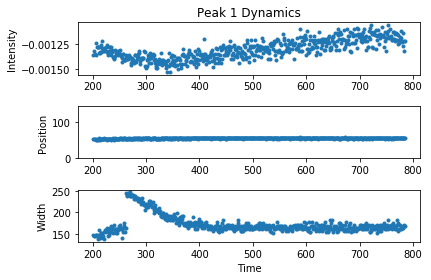

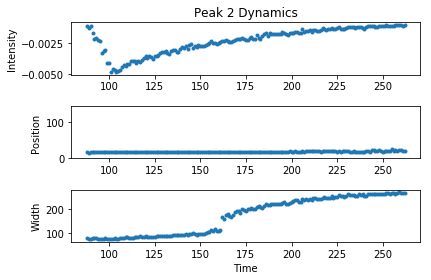

In [115]:
KMeans_output = visualize(peak_dict_KMeans)

# Peak Dynamics Without Classifying

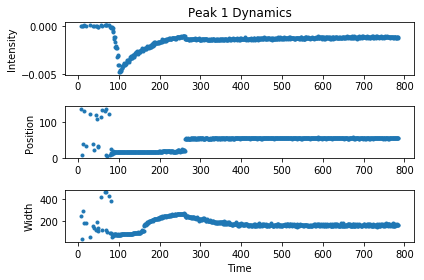

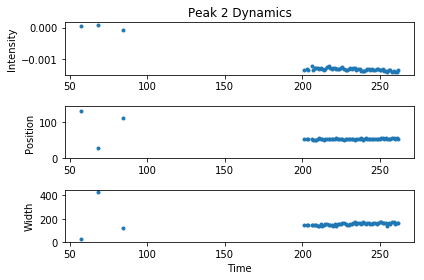

In [116]:
for i in range(idx.shape[1]):
        plt.subplot(3, 1, 1)
        plt.plot(height.loc[:, i], '.')
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(idx.loc[:, i], '.')
        plt.ylabel('Position')
        plt.ylim((0, 144))

        plt.subplot(3, 1, 3)
        plt.plot(fwhm.loc[:, i], '.')
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()

# True Data:
* Peak 1: Intense peak at ~950nm (idx~20), maximum intensity ~-0.005, disappears by time 300.
* Peak 2: Broad peak at ~1100nm (idx~50), maximum intensity ~-0.0015, grows in at time 200 and persists for duration of experiment.

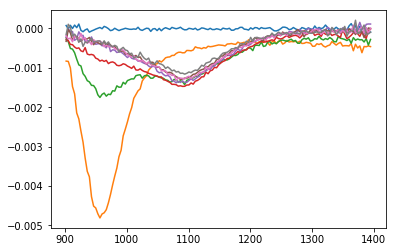

In [117]:
plt.plot(data_nm, data_z[:,1::100])